In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnpå
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import flatten_list
from desc.utils import cross, dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import FourierCurrentPotentialField
from desc.magnetic_fields._current_potential import solve_regularized_surface_current#run_regcoil

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray

# Import my own functions
from desc.fns_simp import (data_eval, _compute_magnetic_field_from_Current,
                           plot_figure,
                           plot_figure2,
                           plot_xy,
                           surf_int)

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64
Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory


<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>


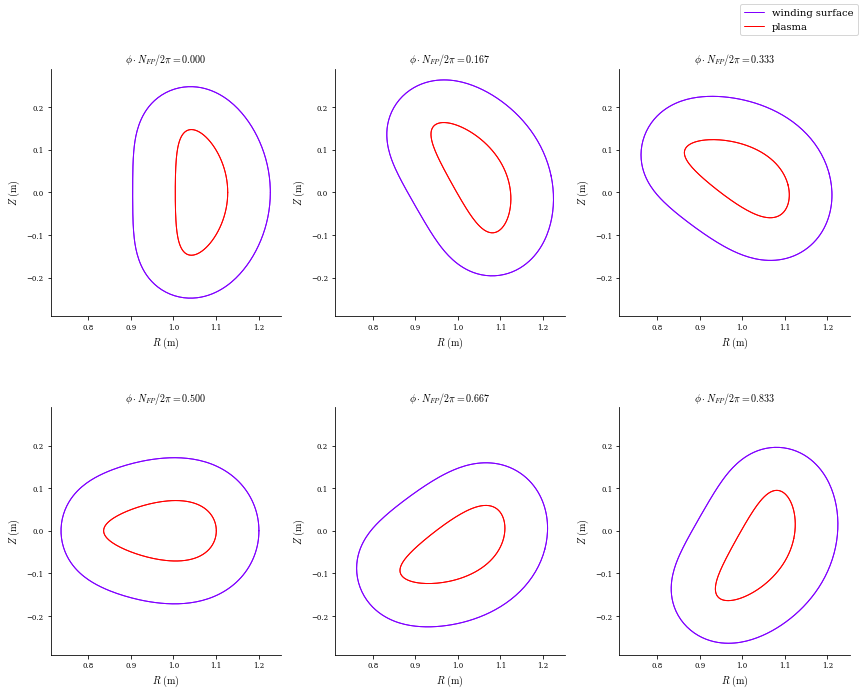

In [3]:
# Plasma surface
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq = desc.io.load(eqname_QA)[4]

# Create a winding surface as a constant offset surface
surf_winding = eq.surface.constant_offset_surface(offset=0.05, # desired offset
                                                  M=16, # Poloidal resolution of desired offset surface
                                                  N=8, # Toroidal resolution of desired offset surface
                                                  grid=LinearGrid(M=32,
                                                                  N=16,
                                                                  NFP=eq.NFP)
                                                 ) # grid of points on base surface to evaluate unit normal 
                                                   # and find points on offset surface,
                                                   # generally should be twice the desired resolution


# Plot both surfaces
plot_comparison([surf_winding,eq],labels=["winding surface","plasma"],theta=0,rho=np.array(1.0))
#plt.savefig("surfaces.png",dpi = 1200)

# Plot both surfaces
winding_surf = FourierCurrentPotentialField.from_surface(surf_winding,
                                                         M_Phi = 1,
                                                         N_Phi = 1,
                                                         )# Winding surface
#plot_comparison([winding_surf,eq],labels=["surf","eq"],theta=0,rho=np.array(1.0))
#plot_comparison([winding_surf,eq],labels=["surf","eq"],theta=0,rho=np.array(1.0))

winding_surf.save("surf.h5")

In [4]:
basis_M = 20
basis_N = 20

# Find surface current K_s
surface_current_field = FourierCurrentPotentialField.from_surface(surf_winding,
                                                                  M_Phi=basis_M,
                                                                  N_Phi=basis_N,
                                                                  #sym_Phi = True
                                                                 )


fields, data = solve_regularized_surface_current(surface_current_field,
                                                 eq,
                                                 lambda_regularization=1e-18,
                                                 current_helicity=(1, 1),
                                                 vacuum=True,
                                                 #regularization_type="regcoil",
                                                 eval_grid=LinearGrid(M=50, N=50, NFP=eq.NFP),
                                                 source_grid=LinearGrid(M=70, N=70, NFP=eq.NFP),
                                                 #vc_source_grid=None,
                                                 #external_field=None,
                                                 #external_field_grid=None,
                                                 #verbose=1,
                                                 kappa = 0,
                                                )

surface_current_field = fields[0] 

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
##########################################################
Calculating Phi_SV for lambda_regularization = 1.00000e-14
##########################################################
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
chi^2 B

In [5]:
surface_current_field.G

-5147546.132306711

In [6]:
surface_current_field.I

-514754.6132306711

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


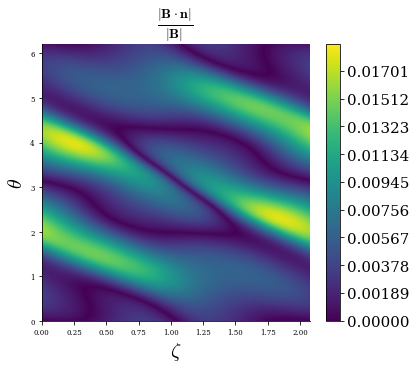

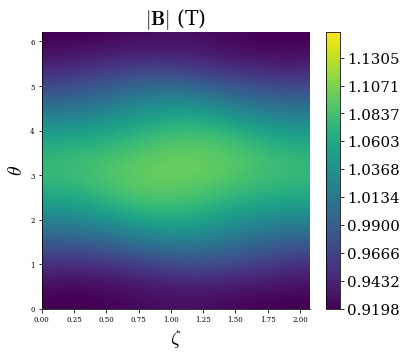

In [7]:
# Find B on plasma surface
egrid = LinearGrid(M = 50, N = 50, NFP = eq.NFP)

coords = eq.compute(["R", "phi", "Z"], grid = egrid)

n_rho = eq.compute("n_rho", grid = egrid)["n_rho"]

#B = coords["B"]
coords = np.vstack([coords["R"], coords["phi"], coords["Z"]]).T

# surface_current_field.compute_magnetic_field actually computes the normal field only
B_from_surf = surface_current_field.compute_magnetic_field(coords,)# grid=egrid)

# Plot B on the plasma surface
mag_B = jnp.sqrt(dot(B_from_surf,B_from_surf))

Bn = abs(dot(B_from_surf,n_rho))*mag_B**(-1) 

plot_figure(Bn,egrid,''r'$\frac{|\mathbf{B} \cdot \mathbf{n}|}{|\mathbf{B}|}$')
plot_figure(mag_B,egrid,''r'$|\mathbf{B}|$ (T)')

In [8]:
surface_current_field.save("surf_opt_2.h5")

In [9]:
kgrid = LinearGrid(M = 80, N = 60, 
                   NFP = eq.NFP
                  )

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


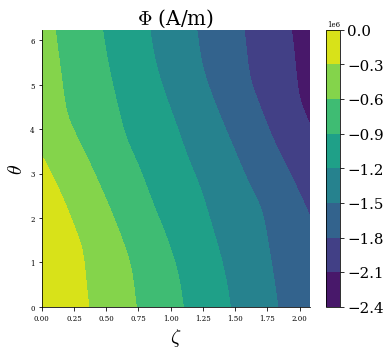

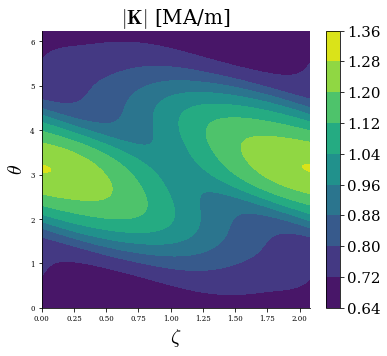

In [10]:
Phi = surface_current_field.compute(["Phi"],grid = kgrid)["Phi"]
K_s = surface_current_field.compute(["K"],grid = kgrid)["K"]

plot_figure2(Phi,kgrid,''r'$\Phi$ (A/m)')
plot_figure2(dot(K_s,K_s)**(1/2)*1e-6,kgrid,''r'$|\mathbf{K}|$ [MA/m]')

In [ ]:
winding_surf.save("surf.h5")